In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Data Loading

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 20s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
shutil.rmtree(os.path.join(train_dir, 'unsup'))

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [13]:
raw_train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review: ", text_batch.numpy()[i])
        print("Label :", label_batch.numpy()[i])

Review:  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0
Review:  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [16]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [17]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Preprocessing

1. <b>Standardization</b> refers to preprocessing the text, typically to remove punctuation or HTML elements
2. <b>Tokenization</b> refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace)
3. <b>Vectorization</b> refers to converting tokens into numbers so they can be fed into a neural network

### 1. Standardization (Custom function, not cleanedup by default)

In [18]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),
                                  '')

### All 3 preprocessing steps

explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Make a text-only dataset (without labels), then call adapt<br>
adapt will be only called on train tp prevent data leakage

In [21]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [32]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [38]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  426,    6,   67, 3775, 3322,   16,   54, 1611,    3,   10,
          68,  131,   12,   71,  192,  446,    9,    9,  269,    2,  769,
         736,  220,  114,  282,    7,    1,   15,    2,   78,    3, 2642,
        2642, 2642,   22, 

In [39]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [40]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [66]:
#return batch of 32 tuple (text[32], y_labe[32])
batch_pf_32 = next(iter(val_ds))
batch_pf_32[0].shape, batch_pf_32[1].shape

(TensorShape([32, 250]), TensorShape([32]))

In [87]:
batch_pf_32[0][1]

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([  10,   89,  118,   48,    2,  954, 2121,   13,  146,   18,   10,
        470,  177,   48,  830,   23,  933, 1244, 1013,    8,   11,   17,
         13,    2, 1101,    4,   52,  921,   19,  107, 5735,    5, 1340,
       7853,    1,    5,    1,  115,   84,    5,    1,    6,    1, 4749,
          1,    5,    2,  206,    3, 4391, 1514, 4323,   21,  108,    8,
          4,   52,   49, 1129,    5,    1, 3639, 8965,  799, 3155,   52,
        447, 2262,   10,  197,  498,    2, 2595,   22,   25,    6, 8779,
          6,    2,    1,    5,    9,    4, 8677,   17,   21,  602,   14,
       3480,  153,  758,  612,    6,    2, 2966,    5,    2,   19,    2,
       1412,   76,  119,  513,  100, 2421,   64, 1455,   64, 1625,    1,
        304,    3,  157,   52, 2784,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

## Configure the dataset for performance

In [89]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [90]:
embedding_dim = 16

In [91]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Loss function and optimizer

In [92]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train your model

In [93]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 43s 66ms/step - loss: 0.6811 - binary_accuracy: 0.6245 - val_loss: 0.6106 - val_binary_accuracy: 0.7738
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5755 - binary_accuracy: 0.7891 - val_loss: 0.4947 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4625 - binary_accuracy: 0.8356 - val_loss: 0.4175 - val_binary_accuracy: 0.8480
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3875 - binary_accuracy: 0.8618 - val_loss: 0.3720 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3412 - binary_accuracy: 0.8762 - val_loss: 0.3437 - val_binary_accuracy: 0.8688
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3087 - binary_accuracy: 0.8901 - val_loss: 0.3250 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 3s 4ms/s

## Evaluate the model

In [94]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 150s 190ms/step - loss: 0.3096 - binary_accuracy: 0.8740
Loss:  0.3096112012863159
Accuracy:  0.873960018157959


##  Create a plot of accuracy and loss over time

In [95]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

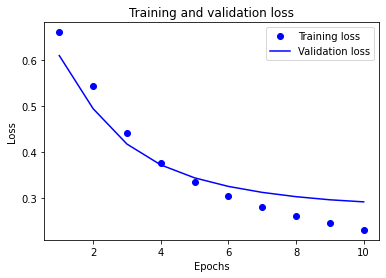

In [96]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

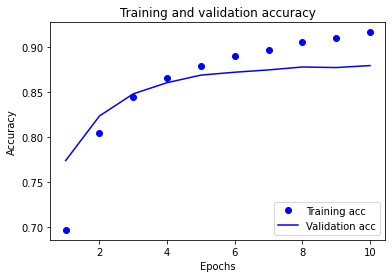

In [97]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In [98]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 18s 22ms/step - loss: 0.3102 - accuracy: 0.8726
0.873960018157959


In [99]:
## Testing with new data

In [100]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6324898 ],
       [0.45520335],
       [0.37260792]], dtype=float32)